## **Augmentation**
* Keras DataGenerator

In [12]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

### **Data Loading**

In [13]:
from tensorflow.keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print("train dataset shape:", train_images.shape, train_labels.shape)
print("test dataset shape:", test_images.shape, test_labels.shape)

train dataset shape: (50000, 32, 32, 3) (50000, 1)
test dataset shape: (10000, 32, 32, 3) (10000, 1)


### **Preprocessing**
rescale을 DataGenerator 이용

In [14]:
def preprocessed_data(images, labels):
    # 이미지 scale 및 float32 형 변형
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    return images, labels

def ohe_data(images, labels):
    # 라벨 원핫인코딩 적용
    images, labels = preprocessed_data(images, labels)
    oh_labels = to_categorical(labels)
    return images, oh_labels

def train_valid_split(train_images, train_labels, test_images, test_labels, valid_size, random_state):
    train_images, train_oh_labels = ohe_data(train_images, train_labels)
    test_images, test_oh_labels = ohe_data(test_images, test_labels)
    train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    return (train_images, train_labels), (val_images, val_labels), (test_images, test_oh_labels)

In [15]:
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = train_valid_split(train_images, train_labels, test_images, test_labels, 0.15, 2021)
print(train_images.shape, train_labels.shape, val_images.shape, val_labels.shape, test_images.shape, test_labels.shape)

(42500, 32, 32, 3) (42500, 10) (7500, 32, 32, 3) (7500, 10) (10000, 32, 32, 3) (10000, 10)


### **Modeling**
* Augmentation
* 모델은 CNN_baseline과 동일

In [16]:
IMAGE_SIZE = 32

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    horizontal_flip=True,
    rescale=1/255.0,
    #vertical_flip,
    #rotation_range,
)
valid_generator = ImageDataGenerator(rescale=1/255.0)

flow_train_gen = train_generator.flow(train_images, train_labels, batch_size = 32)
flow_valid_gen = valid_generator.flow(val_images, val_labels, batch_size = 32, shuffle=False)

In [18]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)) # 배치제외 3차원

x = Conv2D(filters=64, kernel_size=(3,3), padding='same')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=64, kernel_size=(3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Conv2D(filters=128, kernel_size=(3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=(3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Conv2D(filters=256, kernel_size=(3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=256, kernel_size=(3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x) # MaxPooling or Stride 2

# GlobalAveragePooling
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
x = Dense(50, activation='relu', name='GAP1')(x)
x = Dropout(rate=0.2)(x)
output = Dense(train_labels.shape[1], activation='softmax', name='output')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 64)        0   

In [19]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

history = model.fit(flow_train_gen, epochs=30, validation_data=flow_valid_gen, callbacks=[rlr_cb, ely_cb])

Epoch 1/30
1329/1329 [==============================] - 13s 9ms/step - loss: 1.5694 - accuracy: 0.4196 - val_loss: 1.5247 - val_accuracy: 0.4681
Epoch 2/30
1329/1329 [==============================] - 12s 9ms/step - loss: 1.1415 - accuracy: 0.5936 - val_loss: 1.0005 - val_accuracy: 0.6349
Epoch 3/30
1329/1329 [==============================] - 12s 9ms/step - loss: 0.9781 - accuracy: 0.6541 - val_loss: 1.2196 - val_accuracy: 0.5940
Epoch 4/30
1329/1329 [==============================] - 12s 9ms/step - loss: 0.8635 - accuracy: 0.7003 - val_loss: 0.8444 - val_accuracy: 0.7093
Epoch 5/30
1329/1329 [==============================] - 12s 9ms/step - loss: 0.7589 - accuracy: 0.7415 - val_loss: 1.7879 - val_accuracy: 0.4887
Epoch 6/30
1329/1329 [==============================] - 12s 9ms/step - loss: 0.6692 - accuracy: 0.7744 - val_loss: 0.7915 - val_accuracy: 0.7305
Epoch 7/30
1329/1329 [==============================] - 12s 9ms/step - loss: 0.5979 - accuracy: 0.7985 - val_loss: 0.6858 - val_ac

313/313 [==============================] - 2s 5ms/step - loss: 0.4441 - accuracy: 0.8912


[0.44407299160957336, 0.8912000060081482]

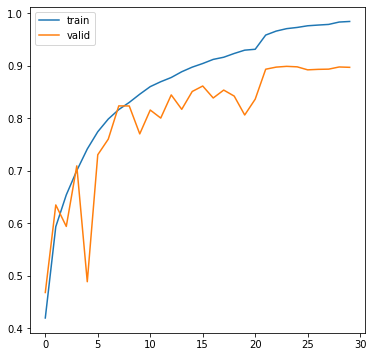

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(6, 6))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(history)

# 테스트 데이터로 성능 평가
test_generator = ImageDataGenerator(rescale=1/255.0)
flow_test_gen = test_generator.flow(test_images, test_labels, shuffle=False)
model.evaluate(flow_test_gen)

* Augmentation은 과적합을 방지할 수 있으나 데이터의 상황에 맞게 효과들을 적용
* keras ImageDataGenerator 말고도 많은 패키지 존재